In [1]:
import pandas as pd
fold1 = pd.read_csv('../data/final/fold1.csv')
fold2 = pd.read_csv('../data/final/fold2.csv')
fold3 = pd.read_csv('../data/final/fold3.csv')
fold4 = pd.read_csv('../data/final/fold4.csv')

/Users/zhannahakhverdyan/anaconda3/envs/predict_dialisys_need/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [2]:
fold1.set_index('Unnamed: 0', inplace=True)
fold2.set_index('Unnamed: 0', inplace=True)
fold3.set_index('Unnamed: 0', inplace=True)
fold4.set_index('Unnamed: 0', inplace=True)
columns = ['BUN', 'bicarbonate', 'calcium', 'chloride',
           'creatinine', 'glucose', 'potassium', 'sodium',
           'BUN_min', 'BUN_mean', 'BUN_max', 'BUN_var', 'bicarbonate_min',
           'bicarbonate_mean', 'bicarbonate_max', 'bicarbonate_var', 'calcium_min',
           'calcium_mean', 'calcium_max', 'calcium_var', 'chloride_min',
           'chloride_mean', 'chloride_max', 'chloride_var', 'creatinine_min',
           'creatinine_mean', 'creatinine_max', 'creatinine_var', 'glucose_min',
           'glucose_mean', 'glucose_max', 'glucose_var', 'potassium_min',
           'potassium_mean', 'potassium_max', 'potassium_var', 'sodium_min',
           'sodium_mean', 'sodium_max', 'sodium_var'
          ]

In [3]:
def relabel_data(df):
    df['time_to_detect'] = pd.to_timedelta(df['time_to_detect'])
    df.loc[df['time_to_detect']<=pd.Timedelta('36h'), 'positive_window'] = 1
    return df
fold1 = relabel_data(fold1)
fold2 = relabel_data(fold2)
fold3 = relabel_data(fold3)
fold4 = relabel_data(fold4)

X_train = pd.concat([fold1[columns], fold2[columns], fold3[columns]], axis=0)
print(X_train.shape)
y_train = pd.concat([fold1['positive_window'], fold2['positive_window'], fold3['positive_window']], axis=0)
print(y_train.shape)
X_test = fold4[columns]
print(X_test.shape)
y_test = fold4['positive_window']
print(y_test.shape)
print(y_train.sum()/len(y_train))
print(y_test.sum()/len(y_test))

(132164, 40)
(132164,)
(43720, 40)
(43720,)
0.12974032262946036
0.1334858188472095


In [4]:
import numpy as np
cv1_train = np.concatenate((np.array(fold1.index), np.array(fold2.index)))
cv1_test = np.array(fold3.index)
cv2_train = np.concatenate((np.array(fold1.index), np.array(fold3.index))) 
cv2_test = np.array(fold2.index)
cv3_train = np.concatenate((np.array(fold2.index), np.array(fold3.index)))
cv3_test = np.array(fold1.index)
custom_cv = []
custom_cv.append((cv1_train, cv1_test))
custom_cv.append((cv2_train, cv2_test))
custom_cv.append((cv3_train, cv3_test))
custom_cv

[(array([   27,    28,    40, ..., 89318, 89319, 89320]),
  array([    5,     6,     7, ..., 89329, 89330, 89331])),
 (array([   27,    28,    40, ..., 89329, 89330, 89331]),
  array([    8,    17,    81, ..., 89318, 89319, 89320])),
 (array([    8,    17,    81, ..., 89329, 89330, 89331]),
  array([   27,    28,    40, ..., 89313, 89321, 89322]))]

In [7]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import average_precision_score, make_scorer
from sklearn.ensemble import RandomForestClassifier

random_state=2020

search_space = [
  {'n_estimators': [50, 100, 200],
   'criterion': ['gini', 'entropy'],
   'max_depth': range(3,13),
   'min_samples_split': [2, 4, 8, 16],
   'min_samples_leaf': range(1,6),
   'max_features': ['sqrt', 'log2', 0.5, None],
   'max_leaf_nodes':[None, 10, 50, 100],
   'min_impurity_decrease': [0, 0.01, 0.05, 0.1],
   'bootstrap': [True, False],
   'ccp_alpha': [0, 0.01, 0.05, 0.1],
   'max_samples': [None, 0.5, 0.8]
  }
]

rf = RandomForestClassifier(n_jobs = -1, random_state=random_state, class_weight = 'balanced_subsample')

# AUC and average precision as score
scoring = {'AUC':'roc_auc', 'Average precision':make_scorer(average_precision_score)}
# Define grid search
grid = RandomizedSearchCV(
                          rf,
                          search_space,
                          cv=custom_cv,
                          scoring=scoring,
                          refit='Average precision',
                          n_iter=250,
                          verbose=1,
                          n_jobs=-1,
                          return_train_score=True
)
# Fit grid search
model = grid.fit(X_train, y_train)


Fitting 3 folds for each of 250 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 23.8min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 97.5min
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed: 143.6min finished


In [9]:
y_pred = grid.best_estimator_.predict_proba(X_test)[:,1]
ap = average_precision_score(y_test, y_pred)
ap

0.3373073155847007

In [10]:
resultsrf = pd.DataFrame({'mean_test_AUC':grid.cv_results_['mean_test_AUC'], \
                        'mean_train_AUC':grid.cv_results_['mean_train_AUC'],\
                        'mean_test_Average precision':grid.cv_results_['mean_test_Average precision'],\
                        'mean_train_Average precision':grid.cv_results_['mean_train_Average precision']})
resultsrf.sort_values(by='mean_test_Average precision', ascending=False).head(30)

,mean_test_AUC,mean_train_AUC,mean_test_Average precision,mean_train_Average precision
12,0.766386,0.782987,0.223404,0.230736
95,0.753905,0.776773,0.221397,0.232080
84,0.752951,0.801251,0.219115,0.242363
20,0.755121,0.797466,0.217921,0.240617
188,0.745341,0.756947,0.217744,0.224675
85,0.749412,0.782008,0.214212,0.229524
69,0.744152,0.776592,0.209588,0.224036
241,0.743935,0.776824,0.209322,0.224241
11,0.736527,0.757689,0.207866,0.215367
87,0.718218,0.723238,0.205900,0.208591


In [11]:
grid.best_params_

{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'min_impurity_decrease': 0,
 'max_samples': None,
 'max_leaf_nodes': 50,
 'max_features': 0.5,
 'max_depth': 10,
 'criterion': 'gini',
 'ccp_alpha': 0,
 'bootstrap': True}

[[0.69828952 0.30171048]
 [0.31374229 0.68625771]]
              precision    recall  f1-score   support

         0.0       0.94      0.70      0.80     37884
         1.0       0.26      0.69      0.38      5836

    accuracy                           0.70     43720
   macro avg       0.60      0.69      0.59     43720
weighted avg       0.85      0.70      0.74     43720



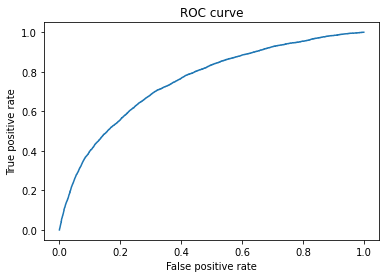

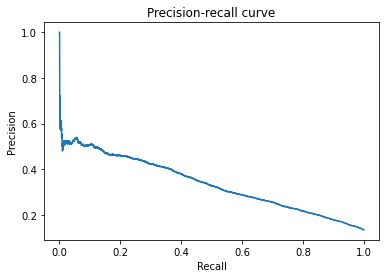

In [12]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

y_score = grid.best_estimator_.predict(X_test)

print(confusion_matrix(y_test,y_score, normalize='true'))
print(classification_report(y_test,y_score))

fpr, tpr, auc_th = roc_curve(y_test, y_pred)
precision, recall, pr_th = precision_recall_curve(y_test, y_pred)

plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-recall curve')
plt.show()

In [15]:
from sklearn.metrics import fbeta_score
f1 = fbeta_score(y_test, y_score, beta=1.0)
f2 = fbeta_score(y_test, y_score, beta=2.0)
print('F1: ', f1)
print('F2: ', f2)

F1:  0.3765690376569038
F2:  0.5163877356301091


In [16]:
import pickle
# save model to file
pickle.dump(grid.best_estimator_, open('../models/rf_tuned.pkl', 'wb'))

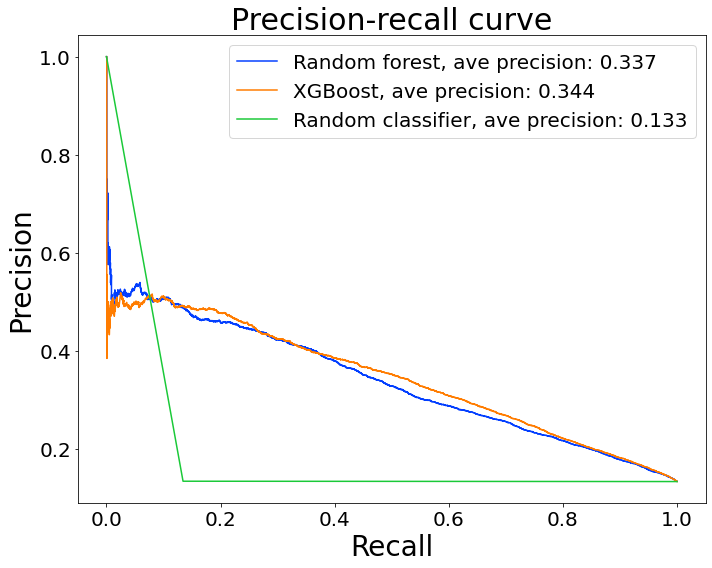

In [22]:
# import data for xgb and random classifier precision and recall curves 
# plot together on the same graph
import seaborn as sns
sns.set_palette("bright")

# create a random classifier for comparison
y_rand = np.zeros(43720)
y_rand[:5836] = 1
np.random.shuffle(y_rand)
precision_r, recall_r, pr_th_r = precision_recall_curve(y_test, y_rand)

xgb_pr = pd.read_csv('../models/xgb_pr.csv')
precision_xgb = xgb_pr['Precision_xgb']
recall_xgb = xgb_pr['Recall_xgb']

plt.figure(figsize=(10,8))
plt.plot(recall, precision, label='Random forest, ave precision: 0.337')
plt.plot(recall_xgb, precision_xgb, label='XGBoost, ave precision: 0.344')
plt.plot(recall_r, precision_r, label='Random classifier, ave precision: 0.133')
plt.xlabel('Recall', fontsize=28)
plt.ylabel('Precision', fontsize=28)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)
plt.title('Precision-recall curve', fontsize=30)
plt.tight_layout()
plt.savefig('../images/pr_curve.png')
plt.show()

In [18]:
average_precision_score(y_test, y_rand)

0.13332662577331578

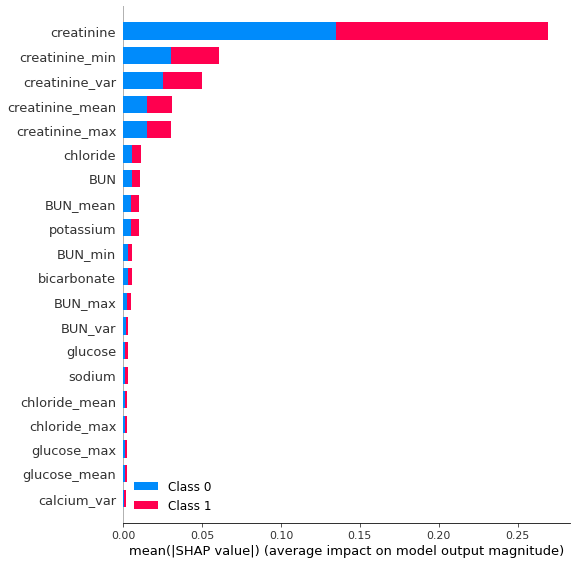

In [24]:
import shap

# Create object that can calculate shap values
explainer = shap.TreeExplainer(grid.best_estimator_)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(X_test)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values, X_test)

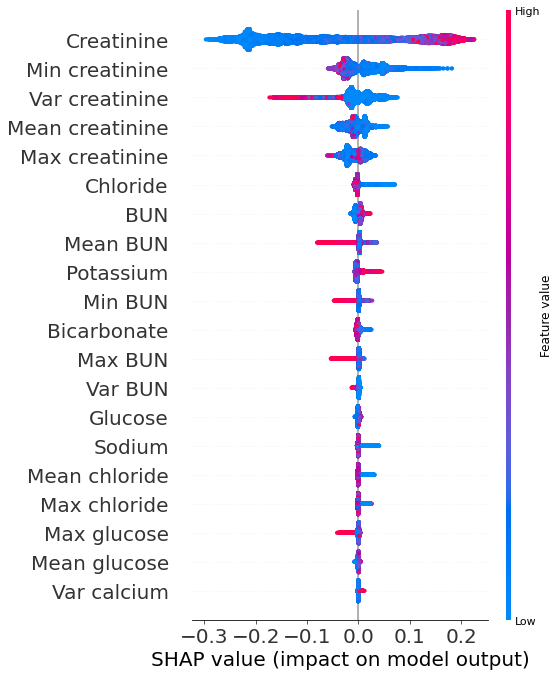

In [41]:
shap.summary_plot(shap_values[1], X_test, show=False)
plt.yticks(np.arange(20), ['Var calcium', 'Mean glucose', 'Max glucose', 'Max chloride', 'Mean chloride', 'Sodium',\
                           'Glucose', 'Var BUN', 'Max BUN', 'Bicarbonate', 'Min BUN', 'Potassium', 'Mean BUN',\
                            'BUN', 'Chloride', 'Max creatinine', 'Mean creatinine', 'Var creatinine', 'Min creatinine', \
                           'Creatinine'
                          ])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('SHAP value (impact on model output)', fontsize=20)
plt.tight_layout()
plt.savefig('../images/rand_forest_shap.png')

In [48]:
fold1.head()

,patientunitstayid,time_to_detect,labresultoffset,akidetection,age,gender,ethnicity,patienthealthsystemstayid,hospitaladmitoffset,unitdischargeoffset,...,glucose_max,glucose_var,potassium_min,potassium_mean,potassium_max,potassium_var,sodium_min,sodium_mean,sodium_max,sodium_var
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
27,141945,2 days 23:00:00,822,5082.0,72,Female,Hispanic,129526,-7,7556,...,177.0,4324.500000,3.8,4.300000,4.8,0.500000,138.0,138.5,139.0,0.5
28,141945,0 days 23:40:00,3662,5082.0,72,Female,Hispanic,129526,-7,7556,...,109.0,312.500000,3.8,4.200000,4.6,0.320000,138.0,138.5,139.0,0.5
40,142683,2 days 01:44:00,1011,3995.0,66,Male,Caucasian,130084,-2,4951,...,164.0,1200.500000,4.0,4.400000,4.8,0.320000,134.0,134.0,134.0,0.0
41,142683,1 days 00:19:00,2536,3995.0,66,Male,Caucasian,130084,-2,4951,...,164.0,852.333333,4.0,4.333333,4.8,0.173333,134.0,134.0,134.0,0.0
87,143476,2 days 23:45:00,1608,5913.0,51,Female,Caucasian,130709,-1712,19503,...,103.0,60.500000,4.3,4.800000,5.3,0.500000,123.0,124.5,126.0,4.5


In [54]:
# fold1.loc[fold1['age'] == '> 89', 'age'] = 91
# fold2.loc[fold2['age'] == '> 89', 'age'] = 91
# fold3.loc[fold3['age'] == '> 89', 'age'] = 91
# fold4.loc[fold4['age'] == '> 89', 'age'] = 91

fold1 = pd.get_dummies(fold1, columns=['gender', 'ethnicity'])
fold2 = pd.get_dummies(fold2, columns=['gender', 'ethnicity'])
fold3 = pd.get_dummies(fold3, columns=['gender', 'ethnicity'])
fold4 = pd.get_dummies(fold4, columns=['gender', 'ethnicity'])


In [59]:
columns_stat = ['BUN', 'bicarbonate', 'calcium', 'chloride',
           'creatinine', 'glucose', 'potassium', 'sodium',
           'BUN_min', 'BUN_mean', 'BUN_max', 'BUN_var', 'bicarbonate_min',
           'bicarbonate_mean', 'bicarbonate_max', 'bicarbonate_var', 'calcium_min',
           'calcium_mean', 'calcium_max', 'calcium_var', 'chloride_min',
           'chloride_mean', 'chloride_max', 'chloride_var', 'creatinine_min',
           'creatinine_mean', 'creatinine_max', 'creatinine_var', 'glucose_min',
           'glucose_mean', 'glucose_max', 'glucose_var', 'potassium_min',
           'potassium_mean', 'potassium_max', 'potassium_var', 'sodium_min',
           'sodium_mean', 'sodium_max', 'sodium_var', 'age', 'gender_Female', 'gender_Male', 'ethnicity_African American', 'ethnicity_Asian',
       'ethnicity_Caucasian', 'ethnicity_Hispanic',
       'ethnicity_Native American', 'ethnicity_Other/Unknown'
          ]

In [60]:
X_train_stat = pd.concat([fold1[columns_stat], fold2[columns_stat], fold3[columns_stat]], axis=0)
print(X_train_stat.shape)
X_test_stat = fold4[columns_stat]
print(X_test_stat.shape)

(132164, 49)
(43720, 49)


In [62]:
params = {'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'min_impurity_decrease': 0,
 'max_samples': None,
 'max_leaf_nodes': 50,
 'max_features': 0.5,
 'max_depth': 10,
 'criterion': 'gini',
 'ccp_alpha': 0,
 'bootstrap': True}

rf_stat = RandomForestClassifier(n_jobs = -1, random_state=random_state, class_weight = 'balanced_subsample', **params)

rf_stat.fit(X_train_stat, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=10, max_features=0.5, max_leaf_nodes=50,
                       max_samples=None, min_impurity_decrease=0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=False,
                       random_state=2020, verbose=0, warm_start=False)

In [65]:
y_pred_stat = rf_stat.predict_proba(X_test_stat)[:,1]
ap = average_precision_score(y_test, y_pred_stat)
ap

0.33812922080141034

In [66]:
stat_feat_imp = pd.DataFrame({'feature importance':rf_stat.feature_importances_, 'feature':columns_stat})
stat_feat_imp.sort_values(by='feature importance', ascending=False)

,feature importance,feature
4,0.467130,creatinine
24,0.150664,creatinine_min
26,0.088909,creatinine_max
27,0.088071,creatinine_var
25,0.075715,creatinine_mean
9,0.019765,BUN_mean
8,0.014083,BUN_min
3,0.011591,chloride
6,0.009997,potassium
10,0.008360,BUN_max
